# Relational Deep Reinforcement Learning

**Plan:**
1. Architecture
2. Agent
3. Environment
4. Training cycle

## Relational architecture

**Input: (b,n,n,1)** = (batch length, linear size, linear size, greyscale)

**Extract entities: (b,n,n,1) -> (b, m, m, 2k)** 
* embedding layer: vocab_size = MAX_PIXELS+1, embedding_dim = n_dim
* convolutional_layer1(kernel_size = (2,2), input_filters = n_dim, output_filters = k, stride = 1, pad = (1,1))
* convolutional_layer2(kernel_size = (2,2), input_filters = k, output_filters = 2k, stride = 1, pad = (1,1))

**Relational block: (b, m, m, 2k) -> (b,d_m)**
* Positional Encoding: (b, m, m, 2k) -> (b, m^2, d_m)
* N Multi-Headed Attention blocks: (b, m^2, d_m) -> (b, m^2, d_m)

**Feature-wise max pooling: (b, m^2, d_m) -> (b, d_m)**

**Multi-Layer Perceptron: (b, d_m) -> (b, d_m)**
* 4 fully connected layers (d_m,d_m) with ReLUs (TODO: add skip-connections)

**Actor output: (b,d_m) -> (b,a)** [a = number of possible actions]
* Single linear layer with softmax at the end

**Critic output: (b,d_m) -> (b,1)** 
* Single linear layer without activation function

## Control architecture

**Input: (b,n,n,1)** = (batch length, linear size, linear size, greyscale)

**Extract entities: (b,n,n,1) -> (b, m, m, 2k)** 
* embedding layer: vocab_size = MAX_PIXELS+1, embedding_dim = n_dim
* convolutional_layer1(kernel_size = (2,2), input_filters = n_dim, output_filters = k, stride = 1, pad = (1,1))
* convolutional_layer2(kernel_size = (2,2), input_filters = k, output_filters = 2k, stride = 1, pad = (1,1))

**1D Convolutional block: (b, m, m, 2k) -> (b, m^2, d_m)**
* Positional Encoding: (b, m, m, 2k) -> (b, m^2, d_m)
* 2 1D convolutional blocks with ReLUs: (b, m^2, d_m) -> (b, m^2, d_m) - pixel-wise

**Feature-wise max pooling: (b, m^2, d_m) -> (b, d_m)**

**Multi-Layer Perceptron: (b, d_m) -> (b, d_m)**
* 4 fully connected layers (d_m,d_m) with ReLUs - feature-wise
* (TODO: add skip-connections)

**Actor output: (b,d_m) -> (b,a)** [a = number of possible actions]
* Single linear layer with softmax at the end

**Critic output: (b,d_m) -> (b,1)** 
* Single linear layer without activation function

In [1]:
import numpy as np
import torch 

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
from RelationalModule import RelationalNetworks as rnet
from RelationalModule import ControlNetworks as cnet

ImportError: cannot import name 'ControlNetworks' from 'RelationalModule' (unknown location)

In [ ]:
from importlib import reload
reload(rnet)
reload(cnet)

# Sample image from the game

In [3]:
import sys
sys.path.insert(0, "pycolab/pycolab/examples/research/box_world")
import box_world as bw

In [4]:
GRID_SIZE = 12
game_params = dict(grid_size=GRID_SIZE,
                solution_length=[2], # number of boxes to be opened to get the gem
                num_forward = [1], # number of distractors
                num_backward=[0], # just set to 0 for now
                branch_length=1, # length of forward distractors
                max_num_steps = 50
               )
game = bw.make_game(**game_params)

observation, _, _ = game.its_showtime()

/home/nicola/anaconda3/envs/torch/lib/python3.7/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


In [5]:
b = observation.board
l = observation.layers
def show_game_state(observation):
    for row in observation.board: print(row.tostring().decode('ascii'))
        
show_game_state(observation)

##############
#            #
#            #
#        *P  #
#  j         #
#         .  #
#            #
#            #
#        hJ  #
#            #
#      pJ    #
#            #
#            #
##############


We can forget about the board and just use the layers' masks to build our custom state.
Chars (symbols) -> object names -> object code

In [6]:
def get_color_dict(seed=100):
    import string
    alphabet = string.ascii_lowercase
    np.random.seed(seed)
    RGB_list = np.random.rand(len(alphabet),3)
    color_dict = {}
    for l, c in zip(alphabet,RGB_list):
        color_dict[l] = c
    np.random.seed(None)
    
    # add colors for 'agent' and  'gem'
    color_dict['agent'] = np.array([1.,0.,0.])
    color_dict['gem'] = np.array([1.,1.,1.])
    
    return color_dict

In [7]:
color_dict = get_color_dict()
object_dict = {'ground':0, 'wall':1, 'agent':2, 'gem':3, 'key':4, 'box':5}
symbol_dict = {' ':'ground', '#':'wall', '.':'agent', '*':'gem'} # key and box can have any possible letter

In [8]:
def show_game_state(observation):
    for row in observation.board: print(row.tostring().decode('ascii'))

b = observation.board
l = observation.layers        
show_game_state(observation)

##############
#            #
#            #
#        *P  #
#  j         #
#         .  #
#            #
#            #
#        hJ  #
#            #
#      pJ    #
#            #
#            #
##############


In [9]:
def get_state(observation):
    b = observation.board
    l = observation.layers  
    color_board = np.zeros(b.shape+(3,)).astype(float)
    object_board = np.zeros(b.shape+(1,)).astype(int)

    for symbol in l.keys():

        # If alphabetic character
        if symbol.isalpha():
            # Paint the color board cells occupied accordingly
            color_board[l[symbol]] = color_dict[symbol.lower()]

            # Upper = box, lower = key
            if symbol.isupper():
                object_board[l[symbol]] = object_dict['box']
            else:
                object_board[l[symbol]] = object_dict['key']

        else:
            object_name = symbol_dict[symbol]

            # Color assigned is [0,0,0] since it's not really a property of those objects
            # Only agent and gem have colors mainly for plotting reasons
            if object_name == 'agent':
                color_board[l[symbol]] = color_dict['agent']
            elif object_name == 'gem':
                color_board[l[symbol]] = color_dict['gem']
            else:
                pass

            object_board[l[symbol]] = object_dict[object_name]
            
    return object_board, color_board
        

In [10]:
object_board, color_board = get_state(observation)
state = (object_board, color_board)

In [11]:
print(object_dict)
print(object_board.reshape(14,14)) # remove last channel for printing

{'ground': 0, 'wall': 1, 'agent': 2, 'gem': 3, 'key': 4, 'box': 5}
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 3 5 0 0 1]
 [1 0 0 4 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 2 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 4 5 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 4 5 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


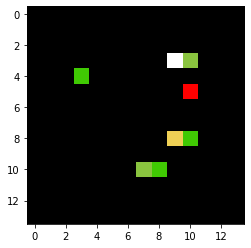

In [12]:
plt.imshow(color_board)

# Embedding layer

In [13]:
# just for simulating an episode - this is one of the outputs of play_episode
states = [state for _ in range(10)]
x1 = torch.LongTensor([s[0] for s in states])
print("x1.shape: ", x1.shape)
x2 = torch.tensor([s[1] for s in states]).float()
print("x2.shape: ", x2.shape)

x1.shape:  torch.Size([10, 14, 14, 1])
x2.shape:  torch.Size([10, 14, 14, 3])


In [14]:
idx = [1,2,3]

In [15]:
vocab_size = len(object_dict)
n_dim = 3
embed = nn.Embedding(vocab_size, n_dim, padding_idx=0) # backgroud is ignored

In [16]:
if len(x1.shape) < 4:
    x1.unsqueeze(0)
x1_embed = embed(x1)
x1_embed = x1_embed.reshape(x1.shape[:3]+(-1,))
print("x1_embed.shape: ", x1_embed.shape)
x = torch.cat((x1_embed, x2), axis = 3)
print('x.shape: ', x.shape)
x = x.transpose(-1,1)
x = x.transpose(-1,-2)
print('x.shape: ', x.shape)

x1_embed.shape:  torch.Size([10, 14, 14, 3])
x.shape:  torch.Size([10, 14, 14, 6])
x.shape:  torch.Size([10, 6, 14, 14])


## Old part using observation.board as state

In [17]:
zeros = torch.ones((10,10), dtype=int)
y_zeros = embed(zeros)
print("y_zeros.shape: ", y_zeros.shape)
print(y_zeros[:,:,0])
print(y_zeros[:,:,1])
print(y_zeros[:,:,2])

y_zeros.shape:  torch.Size([10, 10, 3])
tensor([[1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823,
         1.3823],
        [1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.3823, 1.38

Same integer values get mapped to same vectors, as it should be. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


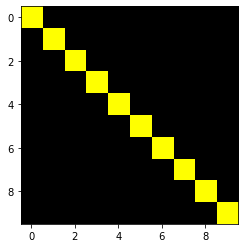

In [18]:
eye = torch.eye(10, dtype=int)
y_eye = embed(eye).detach()
plt.imshow(y_eye.numpy())

Again the embedding works, since each integer value is associated to a particular vector (in this case 3D vector, that can be represented as RGB color once clipped).

In [19]:
for state in states:
    x = state
    if len(x.shape) <= 3:
        x = x.unsqueeze(0)
    #print("x.shape (before embed): ", x.shape)
    x = embed(x)
    #print("x.shape (after embed): ", x.shape)
    #print("x.sum in slices: ", sum_slices(x,(0,1)))
    x = x.transpose(-1,-3)
    #print("x.shape: ", x.shape)
    x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1]).squeeze()
    #print("x.shape: ", x.shape)
    ### This part is just for correct visualization after embedding ###
    x = x.transpose(-1,0)
    x = x.transpose(1,0)
    #print("x.shape: ", x.shape)
    x = x.detach().numpy()
    M = x.max(axis=(0,1))
    m= x.min(axis=(0,1))
    #print("M: ", M.shape )
    #print("m: ", m.shape)
    x = (x - m)/(M-m)
    plt.imshow(x)
    plt.show()

AttributeError: 'tuple' object has no attribute 'shape'

Given this simple rendering (after embedding) from naked eye we can only see that:
1. keys have different colors from the boxes they should open
2. distractors are identical to the right boxes

Then we also have to notice that in this representation colors are biased because I had to normalize in [0,1] the "RGB" channels given by the embedding.

# Convolution layers

In [20]:
use_state = False

In [21]:
k_in = 1
k_out = 24
kernel_size = 2
stride = 1
padding = 0

layers = []
layers.append(nn.Conv2d(n_dim*k_in, k_out//2, kernel_size, stride, padding))
layers.append(nn.ReLU())
layers.append(nn.Conv2d(k_out//2, k_out, kernel_size, stride, padding))
#layers.append(nn.ReLU())
net = nn.Sequential(*layers)

In [22]:
def sum_slices(x, axes):
    return x.squeeze().sum(axis=axes).detach()

In [23]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
y = net(x)
print("y.shape: ", y.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([0., 0., 0.])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
y.shape:  torch.Size([1, 24, 12, 12])


In [24]:
y = y.squeeze().detach()
print(sum_slices(y,(1,2)))
print("y[0,:,:]: ", y[0,:,:])

tensor([ -0.6587, -14.0156,  17.7553,  -2.3413,  -2.9424,  29.2448,   1.5390,
          4.7220,  30.8630,  25.3627,   7.3142,  15.8346,   2.0629,   2.1619,
         -7.3758,  22.1776, -29.9065,  19.2171,  -4.8539,   6.5445,  -5.5534,
          3.2113, -11.2617,  -1.8192])
y[0,:,:]:  tensor([[-0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046,
         -0.0046, -0.0046, -0.0046, -0.0046],
        [-0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046,
         -0.0046, -0.0046, -0.0046, -0.0046],
        [-0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046,
         -0.0046, -0.0046, -0.0046, -0.0046],
        [-0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046,
         -0.0046, -0.0046, -0.0046, -0.0046],
        [-0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046,
         -0.0046, -0.0046, -0.0046, -0.0046],
        [-0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046, -0.0046,


So basically each layer is uniform thanks to the input and how convolution works (each slice is the result of the convolution from the same kernel of the same input). All the zeros that can be seen are due to the ReLU activations.

# Positional Encoding

In [25]:
def add_encoding2D(x):
    x_ax = x.shape[-2]
    y_ax = x.shape[-1]

    x_lin = torch.linspace(-1,1,x_ax)
    xx = x_lin.repeat(x.shape[0],y_ax,1).view(-1, 1, y_ax, x_ax).transpose(3,2)

    y_lin = torch.linspace(-1,1,y_ax).view(-1,1)
    yy = y_lin.repeat(x.shape[0],1,x_ax).view(-1, 1, y_ax, x_ax).transpose(3,2)

    x = torch.cat((x,xx,yy), axis=1)
    return x

In [26]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
y = net(x)
print("y.shape: ", y.shape)
y_enc = add_encoding2D(y)
print("y_enc.shape: ", y_enc.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([0., 0., 0.])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
y.shape:  torch.Size([1, 24, 12, 12])
y_enc.shape:  torch.Size([1, 26, 12, 12])


Let's verify that the last 2 layers have a positional encoding:

y_tmp.shape:  torch.Size([26, 12, 12])


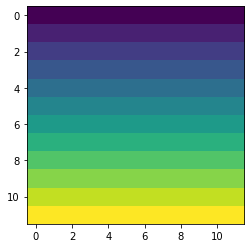

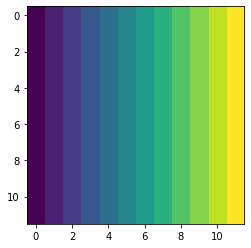

In [27]:
y_tmp = y_enc.squeeze().detach()
print("y_tmp.shape: ", y_tmp.shape)
plt.imshow(y_tmp[-2])
plt.show()
plt.imshow(y_tmp[-1])
plt.show()

A different approach would be to sum these two layers pixel-wise to all other features. Probably it would amplify the importance of the position, at the risk that if the magnitude is too high we would lose data.

Also more complicated encodings are possible; this one is the one I think they used in the paper.

# Projection from 26 to n_features (default 256)

In [28]:
n_features = 256
projection = nn.Linear(k_out + 2, n_features)

In [29]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([0., 0., 0.])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])


Here everything seems clean. Let's see if there is some trace of the positional encoding left. Ideally thanks to the projection now each feature potentially has a positional encoding.

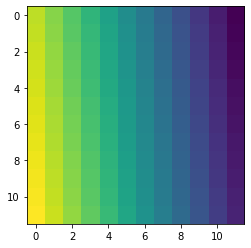

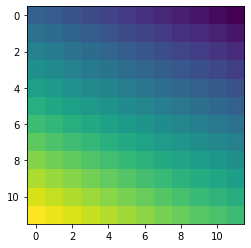

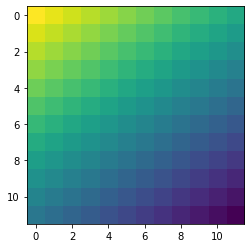

In [30]:
x_tmp = x.squeeze().detach().view(12,12,256)
plt.imshow(x_tmp[:,:,0])
plt.show()
plt.imshow(x_tmp[:,:,128])
plt.show()
plt.imshow(x_tmp[:,:,-2])
plt.show()

Again everything seems fine.

# Relational Block 
Implements the relational block, composed by a Multi-Headed Dot-Product Attention layer followed by a Position-wise Feed-Forward layer. I implement here the former one, whereas I just import the latter from the module, since it's very basic.

In [ ]:
hidden_dim = 64
dropout = 0
n_heads = 4

norm = nn.LayerNorm(n_features)
drop = nn.Dropout(dropout) # disabled
attn = nn.MultiheadAttention(n_features, n_heads, dropout)
ff = rnet.PositionwiseFeedForward(n_features, hidden_dim, dropout)

In [ ]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
out = drop(norm(x_ff))
print("out.shape: ", out.shape)

In [ ]:
def plot_layer(x, layer=0):
    x = x.squeeze().detach()[:,layer]
    plt.imshow(x.view(12,12))
    plt.show()

In [ ]:
print("Input")
plot_layer(x_tmp)
print("Attention output")
plot_layer(attn_output)
print("Input + attention")
plot_layer(x_add)
print("After LayerNorm")
plot_layer(x_norm)
print("After position-wise FF")
plot_layer(x_ff)
print("After LayerNorm")
plot_layer(out)

Here we didn't see anything suspicious, with the attention layer not doing much and the only real change happening during the positionwise feed forward, in which we make a convolution of the 256 features to obtain new ones, so of course after that we are looking at a different feature plane.

To see if the attention layer is working correctly, we can play with the pixel and batch asix and see if the result is affected by those changes. Since the attention mechanism works taking into account relations between pixels, masking some of them should change the output for the others. Instead the batch dimension shouldn't intefrere with the result.

In [ ]:
# Check if batch size changes the output
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp2 = torch.cat((x,x), axis=1)
attn_output, attn_output_weights =  attn(x_tmp2,x_tmp2,x_tmp2, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
out2 = drop(norm(x_ff))
out3 = out2[:,1,:].unsqueeze(1)
out2 = out2[:,0,:].unsqueeze(1)

print("out2.shape: ", out2.shape)
print("out2: ", out2)
print("out: ", out)
print("Element sum of the difference 2-3: ", torch.sum(out2- out3).item())
print("Element sum of the difference 2-0: ", torch.sum(out2- out).item())

out2 = out3 means that the batch dimension correctly hasn't changed the result, because the same input has been concatenated along that axes and the same two outputs have been obtained on the other end. out2 = out shows that different samples are handled independently, as it should happen.

In [ ]:
# Check if pixel sequence changes the output
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)
x_tmp1 = x
x_tmp1[100:] = 0. # mask last 44 positions
attn_output, attn_output_weights =  attn(x_tmp1,x_tmp1,x_tmp1, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
out1 = drop(norm(x_ff))

print("out1: ", out1)
print("out: ", out)
print("Element sum of the difference: ", torch.sum(out1 - out).item())

As can be seen, the new output has changed, as it should.

**LayerNorm formula**
$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

In [ ]:
# What LayerNorm does

E = x_add[0,0,:].mean()
print("E: ", E)
V = x_add[0,0,:].var()
print("V: ", V)
y = (x_add[0,0,:]-E)/torch.sqrt(V+1e-5)
print("LayerNorm by hand: \n", y)
print("LayerNorm: \n", x_norm[0,0,:])

# Featurewise MaxPooling

For each feature, take the maximum value among the pixels.

In [ ]:
x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
x = drop(norm(x_ff))
print("x.shape: ", x.shape)
# Max pooling feature-wise
x, _ = torch.max(x, axis=0)
print("x.shape: ", x.shape)

Nothing much to control here.

# Alternative to max pooling - Linear projection

In [ ]:
reload(rnet)

In [ ]:
linear_proj = nn.Linear(144,1) # needs to know how many pixels there are

In [ ]:
x = torch.zeros((1,1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
x = drop(norm(x_ff))
print("x.shape: ", x.shape)

# Feature-wise projection
x = x.transpose(-1,0)
print("x.shape (before linear): ", x.shape)
shape = x.shape
x = linear_proj(x).reshape(shape[0],shape[1])
print("x.shape: ", x.shape)
x = x.transpose(-1,0)
print("x.shape: ", x.shape)

## Residual Layer

Here the original paper uses just a Multi-Layer Perceptron, but I thought it would be nice to have sone skip connections in order to make the architecture more flexible.

In [ ]:
reload(rnet)

In [ ]:
n_hiddens = 256 
residual_layer = rnet.ResidualLayer(n_features, n_hiddens)

In [ ]:
residual_layer(x) - x # residual after ReLU

# Full architecture

In [208]:
reload(rnet)

<module 'RelationalModule.RelationalNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/RelationalNetworks.py'>

In [209]:
box_net = rnet.BoxWorldNet(in_channels=3, n_kernels=24, vocab_size=6, n_dim=3,
                              n_features=256, n_attn_modules=2, n_linears=4)

Sequential(
  (0): RelationalModule(
    (net): Sequential(
      (0): PositionalEncoding(
        (projection): Linear(in_features=26, out_features=256, bias=True)
      )
      (1): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (attn): MultiheadAttention(
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=64, bias=True)
          (w_2): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (2): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (attn): MultiheadAttention(
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): PositionwiseFeedForward(
        

In [210]:
box_net_v1 = rnet.BoxWorldNet(in_channels=3, n_kernels=24, vocab_size=6, n_dim=3,
                              n_features=256, n_attn_modules=2, n_linears=4, max_pool=False,
                              linear_size=14)

Sequential(
  (0): RelationalModule(
    (net): Sequential(
      (0): PositionalEncoding(
        (projection): Linear(in_features=26, out_features=256, bias=True)
      )
      (1): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (attn): MultiheadAttention(
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=64, bias=True)
          (w_2): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (2): AttentionBlock(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (attn): MultiheadAttention(
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): PositionwiseFeedForward(
        

In [211]:
x1 = torch.LongTensor(state[0])
print(x1.shape)
x2 = torch.tensor(state[1]).float()
print(x2.shape)

torch.Size([14, 14, 1])
torch.Size([14, 14, 3])


In [213]:
y = box_net_v1((x1, x2))
print("y.shape: ", y.shape)
y

x1.shape (before ExtractEntities):  torch.Size([14, 14, 1])
x2.shape (before ExtractEntities):  torch.Size([14, 14, 3])
x.shape (after Embedding and reshape):  torch.Size([1, 6, 14, 14])
x.shape (ExtractEntities):  torch.Size([1, 24, 12, 12])
x.shape (After encoding):  torch.Size([1, 26, 12, 12])
x.shape (Before transposing and projection):  torch.Size([1, 26, 144])
x.shape (PositionalEncoding):  torch.Size([144, 1, 256])
x.shape (RelationalModule):  torch.Size([144, 1, 256])
x.shape (FeaturewiseProjection):  torch.Size([144, 1, 256])
x.shape (FeaturewiseProjection):  torch.Size([256, 1, 144])
x.shape (FeaturewiseProjection):  torch.Size([256, 1])
x.shape (FeaturewiseProjection):  torch.Size([1, 256])
x.shape (BoxWorldNet):  torch.Size([1, 256])
y.shape:  torch.Size([1, 256])


tensor([[-0.0594,  1.1729,  0.9001,  0.4614, -1.3175,  0.0731,  0.9347, -0.9794,
         -1.5173, -0.7390, -0.9998,  2.4710, -1.1093, -0.6915, -3.4846,  2.2579,
         -1.9974, -0.5731, -0.4970, -0.1387,  1.4172,  0.6031,  0.1381,  1.5487,
          0.4061, -0.1736, -0.5689, -0.6867, -1.1547,  0.6612, -0.0434,  0.1895,
         -0.1609,  0.4308,  2.0075,  0.1477,  1.8875,  1.4404, -0.5629, -0.2460,
          1.6132, -1.5495,  1.3293, -1.8583, -0.4135,  0.2229,  0.1548,  2.1788,
         -0.4053,  1.1293,  0.6658,  0.8162,  3.4881,  0.3799,  2.8879,  0.2408,
         -0.2668, -0.1129,  0.8771,  0.1817,  1.6333,  0.5355,  0.5702, -0.9400,
         -0.8138, -0.2316,  0.2152, -2.4184, -1.0042, -0.3276, -0.2822,  1.0378,
          1.4559, -0.2632,  2.6049,  1.5024,  1.4799, -1.2181,  0.9351, -1.7353,
         -1.2603, -0.4981,  0.5729, -0.5147, -1.8516,  0.3851,  0.4077, -1.3375,
          1.4091,  1.5234, -0.9242,  0.9547, -0.4658,  0.6823, -0.6142, -1.1469,
         -1.4122,  0.5281,  